<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/Food_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
drive.mount('/content/drive')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

train, test 데이터 구분


In [ ]:
path = "/content/drive/MyDrive/AIIA AFAC/Original_Food_10"

data_transforms = transforms.Compose([
transforms.RandomResizedCrop(224),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
image_datasets = datasets.ImageFolder(path,data_transforms)

print(image_datasets)

class_names = image_datasets.classes

Dataset ImageFolder
    Number of datapoints: 9029
    Root location: /content/drive/MyDrive/AIIA AFAC/Original_Food_10
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [ ]:
validation_split = .2
batch_size = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "CNN_deep"
shuffle_dataset = True
random_seed= 42

In [ ]:
# training, test 분할을 위한 인덱스 생성
dataset_size = len(image_datasets)
indices = list(range(dataset_size))
test_split = 0.1  # 테스트 데이터 비율 (예: 10%)
split_val = int(np.floor(validation_split * dataset_size))
split_test = int(np.floor(test_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices = indices[split_val + split_test :]
val_indices = indices[split_test:split_val + split_test]
test_indices = indices[:split_test]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, sampler=test_sampler)

inputs, classes = next(iter(train_loader))
print(classes)


tensor([0, 1, 1, 3, 5, 7, 1, 3, 0, 2, 2, 8, 5, 7, 0, 6, 1, 7, 2, 1, 3, 2, 5, 3,
        5, 3, 5, 7, 6, 7, 2, 5])


tensor([2, 1, 3, 3, 3, 3, 7, 3, 8, 3, 7, 2, 7, 2, 3, 2, 7, 6, 6, 7, 4, 8, 5, 1,
        3, 7, 3, 8, 4, 3, 0, 2])


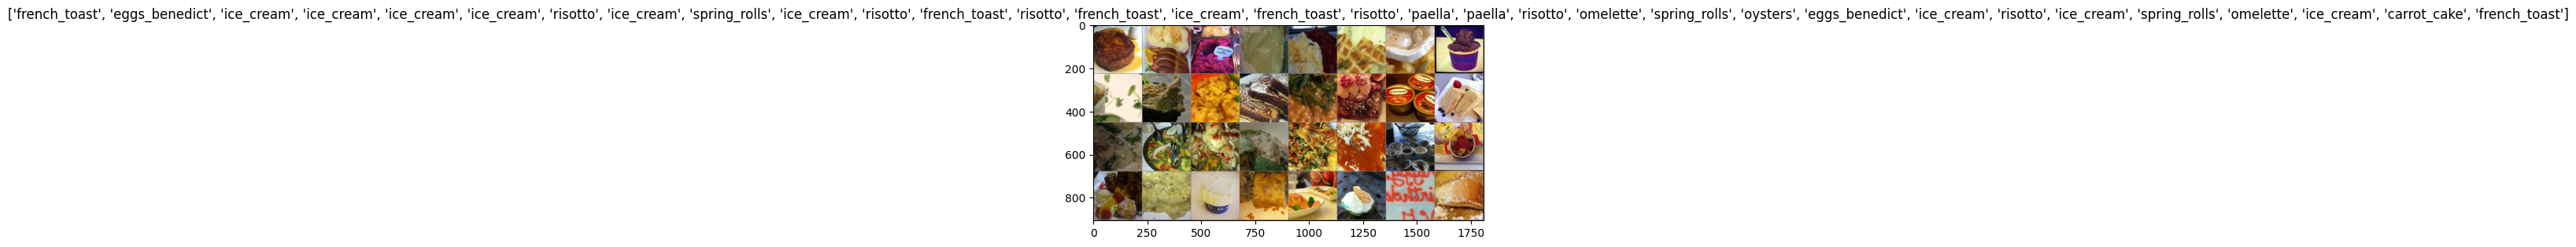

In [ ]:
inputs, classes = next(iter(train_loader))
print(classes)
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout 추가 (30%)
        )
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*28*28, 512),
																				nn.ReLU(),
																				nn.Dropout(0.5),
																				nn.Linear(512, 10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x





In [ ]:
model = CNN_deep().to(DEVICE)


# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 모델 저장 함수
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f" 모델 저장 완료: {path}")

# 모델 불러오기 함수
def load_model(model, path="best_model.pth", device="cpu"):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    print(f" 모델 로드 완료: {path}")
    return model

In [ ]:
# 학습 루프
num_epochs = 10  # 학습할 Epoch 수
best_loss = float("inf")  # 최소 loss 저장용

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # tqdm으로 Progress Bar 추가
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(inputs)  # 모델에 데이터 입력
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()

        # tqdm에 현재 loss 값 업데이트
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # 가장 낮은 Loss일 때 모델 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        save_model(model, "best_model.pth")

# 저장된 모델 불러오기
model = CNN_deep()
model = load_model(model, "best_model.pth", device=DEVICE)


Epoch 1/10:   0%|          | 0/198 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F

def validate_model(model, validation_loader, device):
    model.eval()  # 평가 모드로 변경 (Dropout, BatchNorm 비활성화)
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # 검증 시에는 그래디언트 계산 X (속도 ↑)
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # 모델 예측
            loss = F.cross_entropy(outputs, labels)  # 손실 계산
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)  # 가장 높은 확률의 클래스를 예측값으로 선택
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(validation_loader)  # 평균 손실
    accuracy = correct / total * 100  # 정확도 계산 (%)

    print(f" Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [ ]:
validate_model(model, validation_loader, DEVICE)


NameError: name 'model' is not defined

In [ ]:
from collections import Counter

train_labels = [label for _, label in train_loader.dataset]
val_labels = [label for _, label in validation_loader.dataset]

print("Train Label Distribution:", Counter(train_labels))
print("Validation Label Distribution:", Counter(val_labels))


KeyboardInterrupt: 